In [43]:
# Property Price Prediction - Complete EDA & Modeling Pipeline
# Satellite Imagery-Based Property Valuation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Advanced Models
try:
    import xgboost as xgb
    from xgboost import XGBRegressor
except:
    print("XGBoost not installed. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor
except:
    print("LightGBM not installed. Install with: pip install lightgbm")

try:
    from catboost import CatBoostRegressor
except:
    print("CatBoost not installed. Install with: pip install catboost")

### Load pre-processed data

In [66]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [44]:
X = pd.read_csv("X.csv", index_col=0).squeeze()
print("X.csv loaded!!")
y = pd.read_csv("y.csv", index_col=0).squeeze()
print("y.csv loaded!!")
X_test = pd.read_csv("X_test.csv", index_col=0).squeeze()
print("X_test.csv loaded!!")

print(f"Final feature matrix shape: {X.shape}")
print(f"Test feature matrix shape: {X_test.shape}")

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X.csv loaded!!
y.csv loaded!!
X_test.csv loaded!!
Final feature matrix shape: (16209, 37)
Test feature matrix shape: (5404, 37)
X_train: (12967, 37)
X_val: (3242, 37)
y_train: (12967,)
y_val: (3242,)


In [68]:
X_train.columns

Index(['month_sold', 'property_age', 'floors', 'sqft_living', 'zipcode',
       'yr_built', 'lat', 'sqft_living15', 'lot_vs_neighbors', 'sqft_lot',
       'bathrooms', 'sqft_lot15', 'age_at_sale', 'dist_from_center',
       'was_renovated', 'years_since_renovation', 'living_lot_ratio',
       'sqft_per_bathroom', 'waterfront', 'sqft_above', 'long', 'view',
       'condition', 'above_ratio', 'bedrooms', 'living_vs_neighbors',
       'year_sold', 'has_basement', 'quality_score', 'yr_renovated', 'grade',
       'total_rooms', 'premium_view', 'quarter_sold', 'sqft_per_bedroom',
       'luxury_score', 'sqft_basement'],
      dtype='object')

In [69]:
X_train.head()

,month_sold,property_age,floors,sqft_living,zipcode,yr_built,lat,sqft_living15,lot_vs_neighbors,sqft_lot,...,has_basement,quality_score,yr_renovated,grade,total_rooms,premium_view,quarter_sold,sqft_per_bedroom,luxury_score,sqft_basement
4140,7,68,1.0,1220,98065,1958,47.5297,1100,0.999849,6600,...,0,18,0,6,4.00,0,3,305.0,42.644553,0
1510,8,104,1.5,2010,98108,1922,47.5596,1660,0.816384,3797,...,1,21,2004,7,4.00,0,3,670.0,53.244712,560
6706,11,28,2.0,2570,98074,1998,47.6378,2760,1.162080,7980,...,0,27,0,9,6.50,0,4,514.0,70.668452,0
11009,5,73,1.0,2740,98125,1953,47.7117,2790,1.131133,11343,...,1,50,0,10,6.25,2,2,548.0,79.160781,760
6554,7,20,2.0,5240,98024,2006,47.5605,1930,4.662797,320917,...,0,30,0,10,9.25,2,3,1048.0,85.642676,0


#### 4.4 Feature Scaling

In [45]:
# 4.4 Feature Scaling
print("\n[4.4] Feature Scaling...")

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Scaling complete.")




[4.4] Feature Scaling...
Scaling complete.


### 5. MODEL TRAINING & EVALUATION

In [46]:
# ============================================================================
# 5. MODEL TRAINING & EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("[5] MODEL TRAINING & EVALUATION")
print("=" * 80)

# Dictionary to store results
results = {}

def evaluate_model(name, y_true, y_pred):
    """Calculate and display model metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print(f"\n{name}:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  R²:   {r2:.4f}")
    
    return rmse, mae, r2


[5] MODEL TRAINING & EVALUATION


### 5.1 Baseline Models

#### Linear Regression with Ridge

In [47]:
# 5.1 Baseline Models
print("\n[5.1] Training Baseline Models...")

# Linear Regression with Ridge
print("\n--- Ridge Regression ---")
ridge = Ridge(alpha=10.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_val_scaled)
evaluate_model("Ridge Regression", y_val, y_pred_ridge)


[5.1] Training Baseline Models...

--- Ridge Regression ---

Ridge Regression:
  RMSE: $176,309.49
  MAE:  $116,167.71
  R²:   0.7523


(np.float64(176309.4904085341), 116167.71200782491, 0.7522879858687087)

#### Lasso Regression

In [48]:
# Lasso Regression
print("\n--- Lasso Regression ---")
lasso = Lasso(alpha=10.0)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_val_scaled)
evaluate_model("Lasso Regression", y_val, y_pred_lasso)


--- Lasso Regression ---

Lasso Regression:
  RMSE: $176,422.68
  MAE:  $116,435.43
  R²:   0.7520


(np.float64(176422.67547454863), 116435.4325196561, 0.751969837365946)

#### ElasticNet

In [49]:
# ElasticNet
print("\n--- ElasticNet ---")
elastic = ElasticNet(alpha=10.0, l1_ratio=0.5)
elastic.fit(X_train_scaled, y_train)
y_pred_elastic = elastic.predict(X_val_scaled)
evaluate_model("ElasticNet", y_val, y_pred_elastic)


--- ElasticNet ---

ElasticNet:
  RMSE: $256,368.87
  MAE:  $157,311.26
  R²:   0.4762


(np.float64(256368.8683750909), 157311.25621625464, 0.4762473142825854)

### 5.2 Tree-Based Models

In [50]:
# 5.2 Tree-Based Models
print("\n[5.2] Training Tree-Based Models...")


[5.2] Training Tree-Based Models...


#### Random Forest

In [51]:
# Random Forest
print("\n--- Random Forest ---")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
evaluate_model("Random Forest", y_val, y_pred_rf)


--- Random Forest ---

Random Forest:
  RMSE: $130,427.13
  MAE:  $70,700.17
  R²:   0.8644


(np.float64(130427.13061670805), 70700.17127117384, 0.8644399969037168)

#### Gradient Boosting

In [52]:
# Gradient Boosting
print("\n--- Gradient Boosting ---")
gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_val)
evaluate_model("Gradient Boosting", y_val, y_pred_gb)


--- Gradient Boosting ---

Gradient Boosting:
  RMSE: $121,455.76
  MAE:  $68,275.63
  R²:   0.8824


(np.float64(121455.76197984784), 68275.63104742322, 0.882447482024382)

### 5.3 Advanced Boosting Models

In [53]:
# 5.3 Advanced Boosting Models
print("\n[5.3] Training Advanced Boosting Models...")


[5.3] Training Advanced Boosting Models...


#### XGBoost

In [54]:
# XGBoost
try:
    print("\n--- XGBoost ---")
    xgb_model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_val)
    evaluate_model("XGBoost", y_val, y_pred_xgb)
except:
    print("XGBoost not available. Skipping.")



--- XGBoost ---

XGBoost:
  RMSE: $114,467.30
  MAE:  $65,700.13
  R²:   0.8956


#### LightGBM

In [56]:
# LightGBM
try:
    print("\n--- LightGBM ---")
    lgb_model = LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    )
    lgb_model.fit(X_train, y_train)
    y_pred_lgb = lgb_model.predict(X_val)
    evaluate_model("LightGBM", y_val, y_pred_lgb)
except Exception as e:
    print("LightGBM not available. Skipping.")
    print(e)


--- LightGBM ---

LightGBM:
  RMSE: $118,734.32
  MAE:  $68,662.73
  R²:   0.8877


#### CatBoost

In [57]:
# CatBoost
try:
    print("\n--- CatBoost ---")
    cat_model = CatBoostRegressor(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        random_state=42
    )
    cat_model.fit(X_train, y_train)
    y_pred_cat = cat_model.predict(X_val)
    evaluate_model("CatBoost", y_val, y_pred_cat)
except:
    print("CatBoost not available. Skipping.")


--- CatBoost ---

CatBoost:
  RMSE: $115,332.66
  MAE:  $69,263.67
  R²:   0.8940


### 6. RESULTS VISUALIZATION

In [58]:
# ============================================================================
# 6. RESULTS VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("[6] RESULTS VISUALIZATION")
print("=" * 80)


[6] RESULTS VISUALIZATION


#### 6.1 Model Comparison


Model Performance Summary:
                            RMSE            MAE        R2
XGBoost            114467.296570   65700.132812  0.895586
CatBoost           115332.662665   69263.672223  0.894001
LightGBM           118734.316979   68662.734564  0.887656
Gradient Boosting  121455.761980   68275.631047  0.882447
Random Forest      130427.130617   70700.171271  0.864440
Ridge Regression   176309.490409  116167.712008  0.752288
Lasso Regression   176422.675475  116435.432520  0.751970
ElasticNet         256368.868375  157311.256216  0.476247


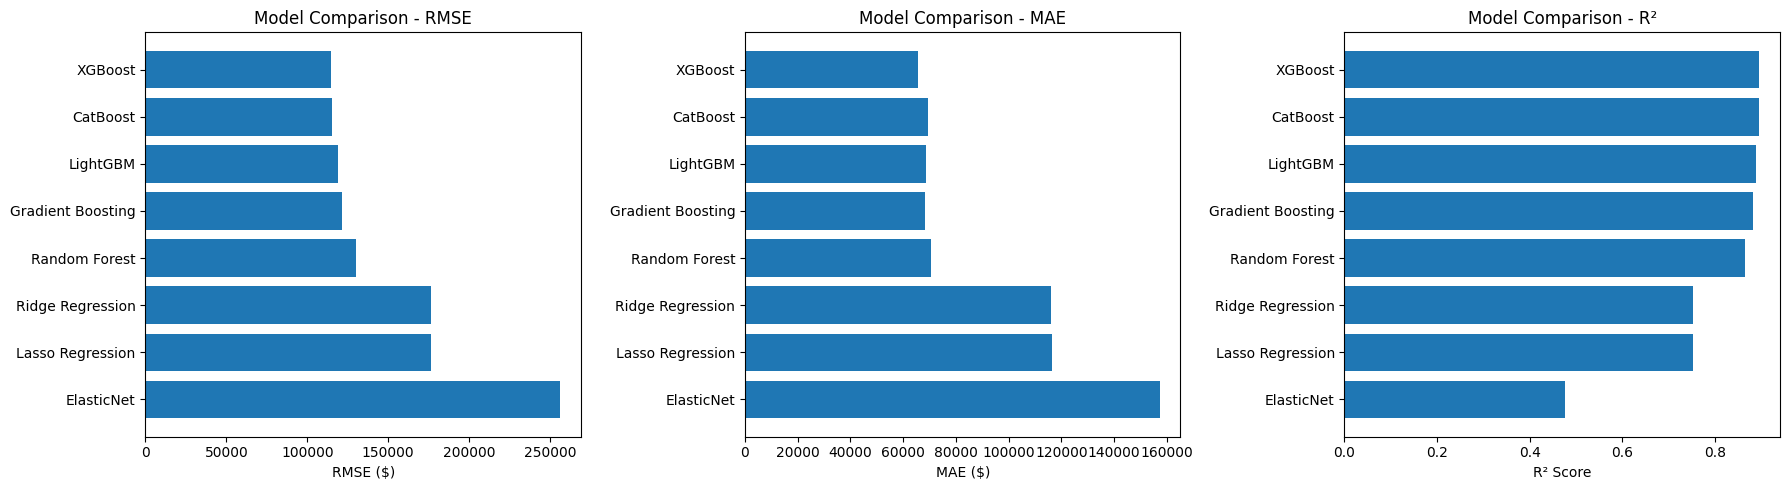

In [59]:
# 6.1 Model Comparison
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')

print("\nModel Performance Summary:")
print(results_df)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
axes[0].barh(results_df.index, results_df['RMSE'])
axes[0].set_xlabel('RMSE ($)')
axes[0].set_title('Model Comparison - RMSE')
axes[0].invert_yaxis()

# MAE comparison
axes[1].barh(results_df.index, results_df['MAE'])
axes[1].set_xlabel('MAE ($)')
axes[1].set_title('Model Comparison - MAE')
axes[1].invert_yaxis()

# R² comparison
axes[2].barh(results_df.index, results_df['R2'])
axes[2].set_xlabel('R² Score')
axes[2].set_title('Model Comparison - R²')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()


#### 6.2 Best Model Analysis


Best Model: XGBoost


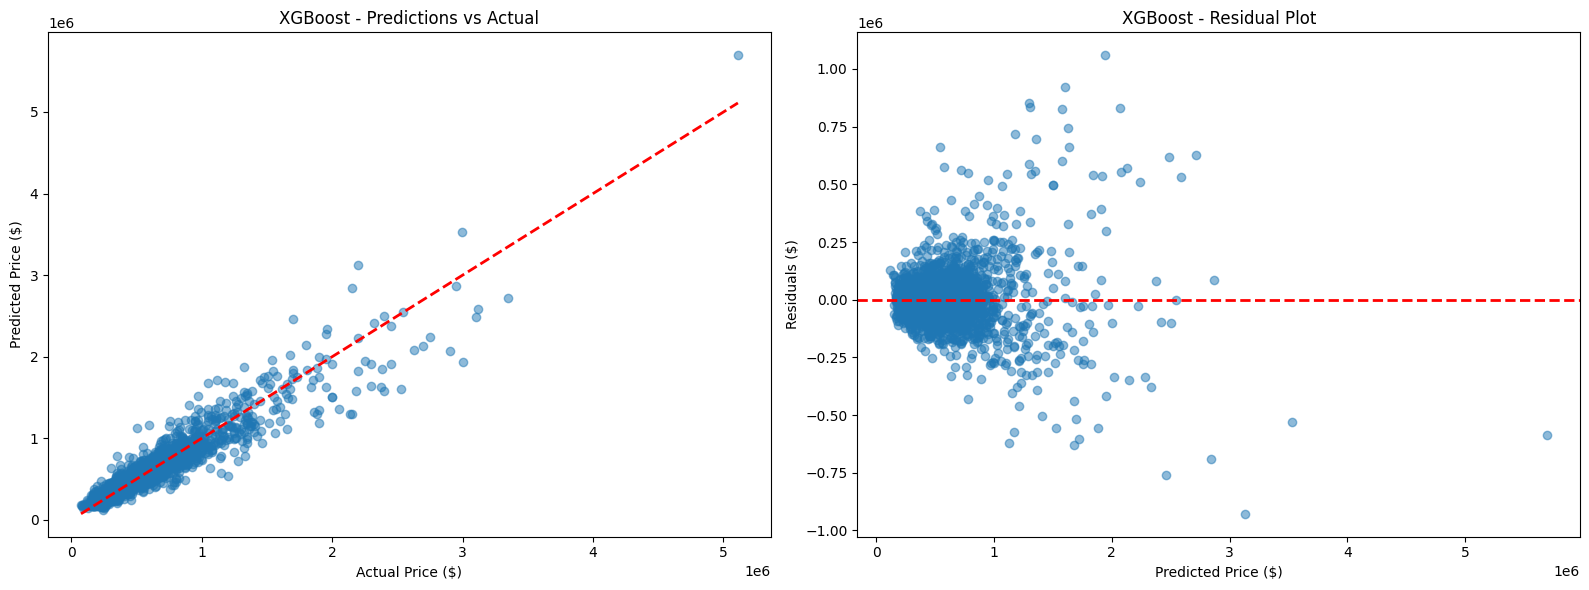

In [60]:
# 6.2 Best Model Analysis
best_model_name = results_df.index[0]
print(f"\nBest Model: {best_model_name}")

# Prediction vs Actual plot
best_predictions = None
if 'XGBoost' in results and best_model_name == 'XGBoost':
    best_predictions = y_pred_xgb
elif 'LightGBM' in results and best_model_name == 'LightGBM':
    best_predictions = y_pred_lgb
elif 'CatBoost' in results and best_model_name == 'CatBoost':
    best_predictions = y_pred_cat
elif best_model_name == 'Random Forest':
    best_predictions = y_pred_rf
elif best_model_name == 'Gradient Boosting':
    best_predictions = y_pred_gb

if best_predictions is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot
    axes[0].scatter(y_val, best_predictions, alpha=0.5)
    axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual Price ($)')
    axes[0].set_ylabel('Predicted Price ($)')
    axes[0].set_title(f'{best_model_name} - Predictions vs Actual')
    
    # Residual plot
    residuals = y_val - best_predictions
    axes[1].scatter(best_predictions, residuals, alpha=0.5)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Price ($)')
    axes[1].set_ylabel('Residuals ($)')
    axes[1].set_title(f'{best_model_name} - Residual Plot')
    
    plt.tight_layout()
    plt.show()


#### 6.3 Feature Importance


[6.3] Feature Importance Analysis

Top 20 Most Important Features:
             feature  importance
35      luxury_score    0.324786
18        waterfront    0.073502
3        sqft_living    0.071591
32      premium_view    0.062881
13  dist_from_center    0.052546
30             grade    0.050386
6                lat    0.047631
10         bathrooms    0.033173
19        sqft_above    0.031508
7      sqft_living15    0.026790
21              view    0.025429
12       age_at_sale    0.019791
14     was_renovated    0.014841
34  sqft_per_bedroom    0.014821
20              long    0.014449
5           yr_built    0.014333
29      yr_renovated    0.012779
28     quality_score    0.011243
4            zipcode    0.010680
1       property_age    0.010061


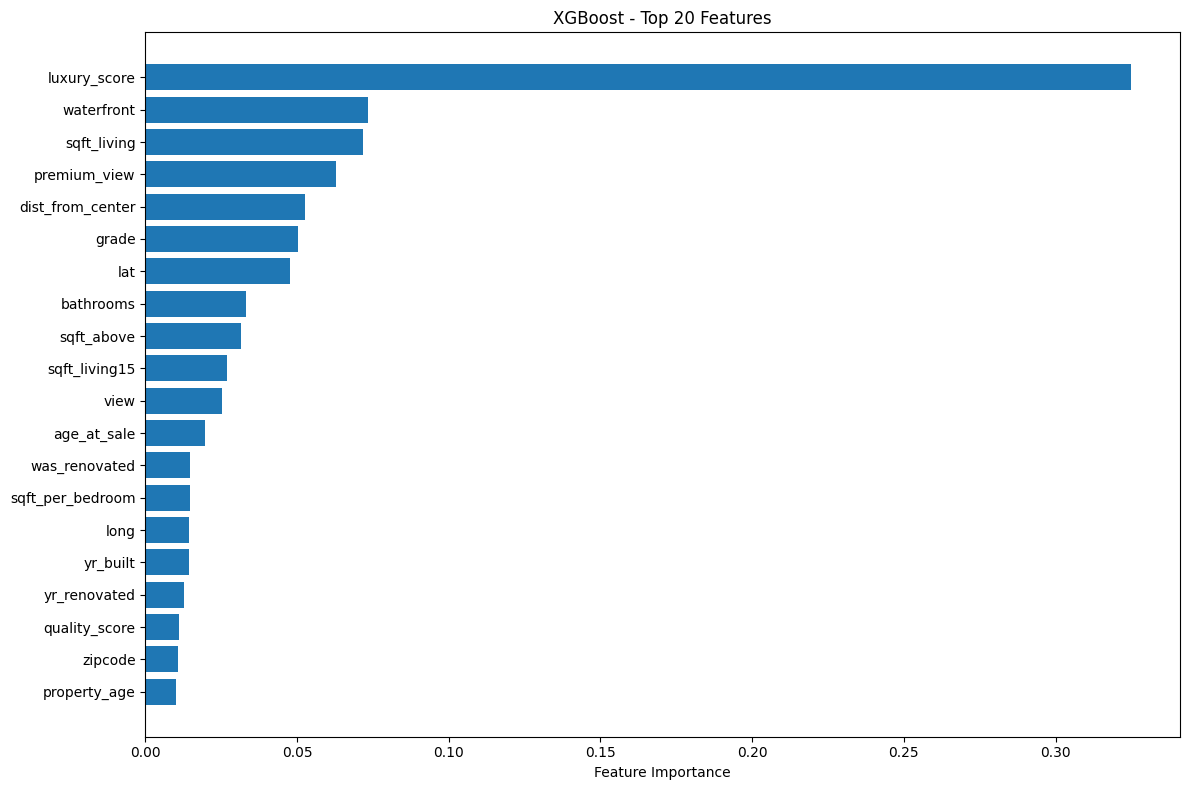

In [61]:
# 6.3 Feature Importance
print("\n[6.3] Feature Importance Analysis")

feature_importance = None
if 'XGBoost' in results and best_model_name == 'XGBoost':
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
elif 'LightGBM' in results and best_model_name == 'LightGBM':
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': lgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
elif 'CatBoost' in results and best_model_name == 'CatBoost':
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': cat_model.feature_importances_
    }).sort_values('importance', ascending=False)
elif best_model_name == 'Random Forest':
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
elif best_model_name == 'Gradient Boosting':
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': gb.feature_importances_
    }).sort_values('importance', ascending=False)

if feature_importance is not None:
    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20))
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance.head(20)
    plt.barh(range(len(top_20)), top_20['importance'])
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'{best_model_name} - Top 20 Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


### 7. FINAL PREDICTIONS ON TEST SET

In [64]:
# ============================================================================
# 7. FINAL PREDICTIONS ON TEST SET
# ============================================================================

print("\n" + "=" * 80)
print("[7] GENERATING FINAL PREDICTIONS")
print("=" * 80)

# Use best model to make predictions
if 'XGBoost' in results and best_model_name == 'XGBoost':
    final_predictions = xgb_model.predict(X_test)
elif 'LightGBM' in results and best_model_name == 'LightGBM':
    final_predictions = lgb_model.predict(X_test)
elif 'CatBoost' in results and best_model_name == 'CatBoost':
    final_predictions = cat_model.predict(X_test)
elif best_model_name == 'Random Forest':
    final_predictions = rf.predict(X_test)
elif best_model_name == 'Gradient Boosting':
    final_predictions = gb.predict(X_test)
else:
    final_predictions = ridge.predict(X_test_scaled)

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'predicted_price': final_predictions
})

# Save to CSV
submission.to_csv('price_predictions.csv', index=False)
print("\nPredictions saved to 'price_predictions.csv'")
print(f"\nSubmission shape: {submission.shape}")
print("\nFirst 10 predictions:")
print(submission.head(10))



[7] GENERATING FINAL PREDICTIONS

Predictions saved to 'price_predictions.csv'

Submission shape: (5404, 2)

First 10 predictions:
           id  predicted_price
0  2591820310     3.754576e+05
1  7974200820     8.812118e+05
2  7701450110     1.094845e+06
3  9522300010     2.233111e+06
4  9510861140     7.443174e+05
5  1761300310     2.421249e+05
6  7732410120     8.012166e+05
7  7010701383     6.232807e+05
8   291310170     4.157497e+05
9  4232901990     5.452641e+05


### 8. ENSEMBLE APPROACH

In [65]:
# ============================================================================
# 8. ENSEMBLE APPROACH
# ============================================================================

print("\n" + "=" * 80)
print("[8] ENSEMBLE PREDICTIONS")
print("=" * 80)

# Create ensemble from top models
ensemble_predictions = []

try:
    ensemble_predictions.append(xgb_model.predict(X_val))
    print("✓ XGBoost included in ensemble")
except:
    pass

try:
    ensemble_predictions.append(lgb_model.predict(X_val))
    print("✓ LightGBM included in ensemble")
except:
    pass

try:
    ensemble_predictions.append(cat_model.predict(X_val))
    print("✓ CatBoost included in ensemble")
except:
    pass

ensemble_predictions.append(rf.predict(X_val))
print("✓ Random Forest included in ensemble")

ensemble_predictions.append(gb.predict(X_val))
print("✓ Gradient Boosting included in ensemble")

# Average predictions
ensemble_pred = np.mean(ensemble_predictions, axis=0)
evaluate_model("Ensemble (Average)", y_val, ensemble_pred)

# Weighted ensemble (if we have multiple models)
if len(ensemble_predictions) >= 3:
    # Weight by inverse RMSE
    weights = []
    models_in_ensemble = []
    
    for model_name in ['XGBoost', 'LightGBM', 'CatBoost', 'Random Forest', 'Gradient Boosting']:
        if model_name in results:
            models_in_ensemble.append(model_name)
            weights.append(1 / results[model_name]['RMSE'])
    
    # Normalize weights
    weights = np.array(weights[:len(ensemble_predictions)])
    weights = weights / weights.sum()
    
    weighted_ensemble_pred = np.average(ensemble_predictions, axis=0, weights=weights)
    evaluate_model("Weighted Ensemble", y_val, weighted_ensemble_pred)
    
    print("\nEnsemble Weights:")
    for i, model in enumerate(models_in_ensemble[:len(weights)]):
        print(f"  {model}: {weights[i]:.4f}")

# Generate final ensemble predictions for test set
print("\n\nGenerating ensemble predictions for test set...")

test_ensemble_predictions = []

try:
    test_ensemble_predictions.append(xgb_model.predict(X_test))
except:
    pass

try:
    test_ensemble_predictions.append(lgb_model.predict(X_test))
except:
    pass

try:
    test_ensemble_predictions.append(cat_model.predict(X_test))
except:
    pass

test_ensemble_predictions.append(rf.predict(X_test))
test_ensemble_predictions.append(gb.predict(X_test))

# Average ensemble
test_ensemble_avg = np.mean(test_ensemble_predictions, axis=0)

# Create ensemble submission
ensemble_submission = pd.DataFrame({
    'id': test_df['id'],
    'predicted_price': test_ensemble_avg
})

ensemble_submission.to_csv('price_predictions_ensemble.csv', index=False)
print("Ensemble predictions saved to 'price_predictions_ensemble.csv'")



[8] ENSEMBLE PREDICTIONS
✓ XGBoost included in ensemble
✓ LightGBM included in ensemble
✓ CatBoost included in ensemble
✓ Random Forest included in ensemble
✓ Gradient Boosting included in ensemble

Ensemble (Average):
  RMSE: $115,440.80
  MAE:  $66,029.59
  R²:   0.8938

Weighted Ensemble:
  RMSE: $115,235.06
  MAE:  $66,011.24
  R²:   0.8942

Ensemble Weights:
  XGBoost: 0.2094
  LightGBM: 0.2018
  CatBoost: 0.2078
  Random Forest: 0.1837
  Gradient Boosting: 0.1973


Generating ensemble predictions for test set...
Ensemble predictions saved to 'price_predictions_ensemble.csv'


### 9. SUMMARY & RECOMMENDATIONS

In [67]:

# ============================================================================
# 9. SUMMARY & RECOMMENDATIONS
# ============================================================================

print("\n" + "=" * 80)
print("[9] SUMMARY & NEXT STEPS")
print("=" * 80)

print(f"""
ANALYSIS COMPLETE
=================

Dataset Overview:
- Training samples: {len(train_df):,}
- Test samples: {len(test_df):,}
- Features engineered: {X.shape[1]}

Best Performing Model: {best_model_name}
- RMSE: ${results[best_model_name]['RMSE']:,.2f}
- MAE: ${results[best_model_name]['MAE']:,.2f}
- R²: {results[best_model_name]['R2']:.4f}

Top 5 Important Features (if available):
""")

if feature_importance is not None:
    for i, row in feature_importance.head(5).iterrows():
        print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

print("""
NEXT STEPS FOR MULTIMODAL APPROACH:
====================================

1. SATELLITE IMAGE ACQUISITION:
   - Use lat/long coordinates to fetch satellite images
   - Recommended APIs:
     * Google Maps Static API
     * Mapbox Static Images API
     * Sentinel Hub
   - Suggested image size: 640x640 pixels
   - Zoom level: 17-18 (for property-level detail)

2. IMAGE PREPROCESSING:
   - Normalize pixel values (0-1)
   - Data augmentation (rotation, flips)
   - Create image embeddings using pre-trained CNNs:
     * ResNet50/101
     * EfficientNet
     * Vision Transformer (ViT)

3. MULTIMODAL FUSION ARCHITECTURES:
   a) Early Fusion: Concatenate image features with tabular data
   b) Late Fusion: Train separate models and combine predictions
   c) Hybrid Fusion: Multiple fusion points in the network

4. MODEL EXPLAINABILITY:
   - Implement Grad-CAM for satellite images
   - SHAP values for tabular features
   - Visualize what image regions influence price

5. ADVANCED TECHNIQUES:
   - Attention mechanisms to weight important regions
   - Graph Neural Networks for neighborhood effects
   - Geospatial embeddings

FILES GENERATED:
- price_predictions.csv (Best single model)
- price_predictions_ensemble.csv (Ensemble model)

Current Phase Complete: ✓ Tabular Data Analysis & Modeling
Next Phase: Satellite Image Integration
""")


[9] SUMMARY & NEXT STEPS

ANALYSIS COMPLETE

Dataset Overview:
- Training samples: 16,209
- Test samples: 5,404
- Features engineered: 37

Best Performing Model: XGBoost
- RMSE: $114,467.30
- MAE: $65,700.13
- R²: 0.8956

Top 5 Important Features (if available):

  36. luxury_score: 0.3248
  19. waterfront: 0.0735
  4. sqft_living: 0.0716
  33. premium_view: 0.0629
  14. dist_from_center: 0.0525

NEXT STEPS FOR MULTIMODAL APPROACH:

1. SATELLITE IMAGE ACQUISITION:
   - Use lat/long coordinates to fetch satellite images
   - Recommended APIs:
     * Google Maps Static API
     * Mapbox Static Images API
     * Sentinel Hub
   - Suggested image size: 640x640 pixels
   - Zoom level: 17-18 (for property-level detail)

2. IMAGE PREPROCESSING:
   - Normalize pixel values (0-1)
   - Data augmentation (rotation, flips)
   - Create image embeddings using pre-trained CNNs:
     * ResNet50/101
     * EfficientNet
     * Vision Transformer (ViT)

3. MULTIMODAL FUSION ARCHITECTURES:
   a) Early Fu